# Analyse Exploratoire des Données de Catastrophes Naturelles

Ce notebook présente une analyse exploratoire complète d'un jeu de données portant sur les catastrophes naturelles du challenge. L'objectif est de nettoyer les données, comprendre les relations entre les variables environnementales (température, humidité, sismicité, pluie) et les différents types de catastrophes, ainsi que leur répartition géographique par quartier.

## Table des matières

1. [Imports et préparation](#imports)
2. [Normalisation et nettoyage des données](#normalisation)
3. [Visualisations](#visualisation)
   - Distribution des types de catastrophes
   - Corrélations entre variables
   - Relations entre variables environnementales et catastrophes
   - Répartition par quartier
4. [Analyse temporelle](#temporelle)
   - Détection des coupures dans les séries temporelles
   - Visualisation des observations par date

# Imports

In [237]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# Traitement des données

## Nettoyage du fichier brut CSV
Le fichier CSV contient des lignes mal formatées, comme l'exemple ci-dessous :
````csv
"1221,26.6,60.3,4.5,15.0,0.0,2170-10-02,Zone 2,0.81,287.96,145.65,""['innondation', 'seisme']"""
````
Le code suivant corrige ces lignes pour les rendre conformes au bon format.

In [238]:
with open('data_raw.csv', 'r', encoding='utf-8') as infile, open('data_clean.csv', 'w', encoding='utf-8') as outfile:
    for ligne in infile:
        if ligne.strip():  
            if ligne.startswith('"'):
                ligne = ligne[1:]
                ligne = ligne.replace('"""', '"')
                ligne = ligne.replace('""', '"')
            outfile.write(ligne)
            

In [239]:
df = pl.read_csv('data_clean.csv', has_header=True, schema_overrides={'date':pl.Date})

Chargement de la donnée en mémoire avec polars

In [240]:
df.head(5)

,temperature,humidite,force_moyenne_du_vecteur_de_vent,force_du_vecteur_de_vent_max,pluie_intensite_max,date,quartier,sismicite,concentration_gaz,pluie_totale,catastrophe
i64,f64,f64,f64,f64,f64,date,str,f64,f64,f64,str
0,5.7,75.6,3.8,4.3,0.0,2170-01-01,"""Zone 1""",0.62,231.56,182.37,"""aucun"""
1,5.7,75.6,3.8,4.3,0.0,2170-01-01,"""Zone 2""",0.94,248.2,903.2,"""['seisme']"""
2,5.7,75.6,3.8,4.3,0.0,2170-01-01,"""Zone 3""",0.95,240.55,363.06,"""['seisme']"""
3,5.7,75.6,3.8,4.3,0.0,2170-01-01,"""Zone 4""",0.39,159.1,473.93,"""aucun"""
4,5.7,75.6,3.8,4.3,0.0,2170-01-01,"""Zone 5""",0.41,143.29,475.72,"""['innondation']"""


In [241]:
df.describe()

statistic,,temperature,humidite,force_moyenne_du_vecteur_de_vent,force_du_vecteur_de_vent_max,pluie_intensite_max,date,quartier,sismicite,concentration_gaz,pluie_totale,catastrophe
str,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,str
"""count""",3395.0,3395.0,3395.0,3395.0,3395.0,3395.0,"""3395""","""3395""",3395.0,3395.0,3395.0,"""3395"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,"""0"""
"""mean""",1697.0,23.101178,56.239175,5.796907,11.547275,0.0081,"""2171-01-06 17:27:39.499000""",null,0.648162,194.305184,462.21762,null
"""std""",980.196409,10.415629,13.47398,3.366256,7.004531,0.031777,null,null,0.178118,53.029867,271.815926,null
"""min""",0.0,-29.7,13.4,1.1,0.0,0.0,"""2170-01-01""","""Zone 1""",0.3,100.08,0.1,"""['innondation', 'seisme']"""
"""25%""",849.0,15.7,46.7,3.5,6.9,0.0,"""2170-06-22""",null,0.53,155.32,229.65,null
"""50%""",1697.0,21.3,58.2,4.7,10.3,0.0,"""2171-01-19""",null,0.64,186.9,457.73,null
"""75%""",2546.0,31.3,66.5,6.9,14.6,0.0,"""2171-07-10""",null,0.79,236.83,681.79,null
"""max""",3394.0,46.3,84.7,32.3,57.6,0.3,"""2171-12-31""","""Zone 5""",1.0,299.9,999.87,"""aucun"""


Les données ne contiennent pas de valeurs manquantes et aucune anomalie aparait

In [242]:
df.dtypes

[Int64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Date,
 String,
 Float64,
 Float64,
 Float64,
 String]

Les colonnes Quartier et Catastrophe sont des chaines de caractères. Il faudra peut-être les encodé avec des entiers

In [243]:
df["quartier"].unique()

quartier
str
"""Zone 4"""
"""Zone 2"""
"""Zone 5"""
"""Zone 3"""
"""Zone 1"""


In [244]:
df = df.with_columns(
    (pl.col("quartier").str.replace_all(r"\D", "")).cast(pl.Int64, strict=False).alias("quartier")
)
df.head()

,temperature,humidite,force_moyenne_du_vecteur_de_vent,force_du_vecteur_de_vent_max,pluie_intensite_max,date,quartier,sismicite,concentration_gaz,pluie_totale,catastrophe
i64,f64,f64,f64,f64,f64,date,i64,f64,f64,f64,str
0,5.7,75.6,3.8,4.3,0.0,2170-01-01,1,0.62,231.56,182.37,"""aucun"""
1,5.7,75.6,3.8,4.3,0.0,2170-01-01,2,0.94,248.2,903.2,"""['seisme']"""
2,5.7,75.6,3.8,4.3,0.0,2170-01-01,3,0.95,240.55,363.06,"""['seisme']"""
3,5.7,75.6,3.8,4.3,0.0,2170-01-01,4,0.39,159.1,473.93,"""aucun"""
4,5.7,75.6,3.8,4.3,0.0,2170-01-01,5,0.41,143.29,475.72,"""['innondation']"""


La colonne quartier contient désormé uniquement le chiffre de leur zone

In [245]:
df["catastrophe"].unique()

catastrophe
str
"""['innondation']"""
"""aucun"""
"""['seisme']"""
"""['innondation', 'seisme']"""


La colonne catastrophe ne contient que 4 valeurs, nous pouvons donc les encoder par des entiers

In [246]:
catastrophes = df["catastrophe"].unique().to_list()
df = df.with_columns(
    pl.col("catastrophe").map_elements(
        lambda x: catastrophes.index(x), return_dtype=pl.Int64
    ).alias("catastrophe")
)

La colonne catastrophe est désormais encodé par des chiffres selont les 4 valeurs possibles

In [247]:
df = df.sort("date")

In [248]:
df.write_csv('data_for_model.csv')

# Visualisation

In [249]:
df_pd = df.to_pandas()

Convertion en DataFrame pandas pour la compatibilité avec seaborn

## Distribution des quartiers

Avant d'explorer les relations entre les catastrophes et les variables environnementales, analysons d'abord la répartition des observations par quartier. Cette visualisation nous permettra de comprendre si certains quartiers sont surreprésentés dans notre jeu de données, ce qui pourrait influencer nos conclusions.

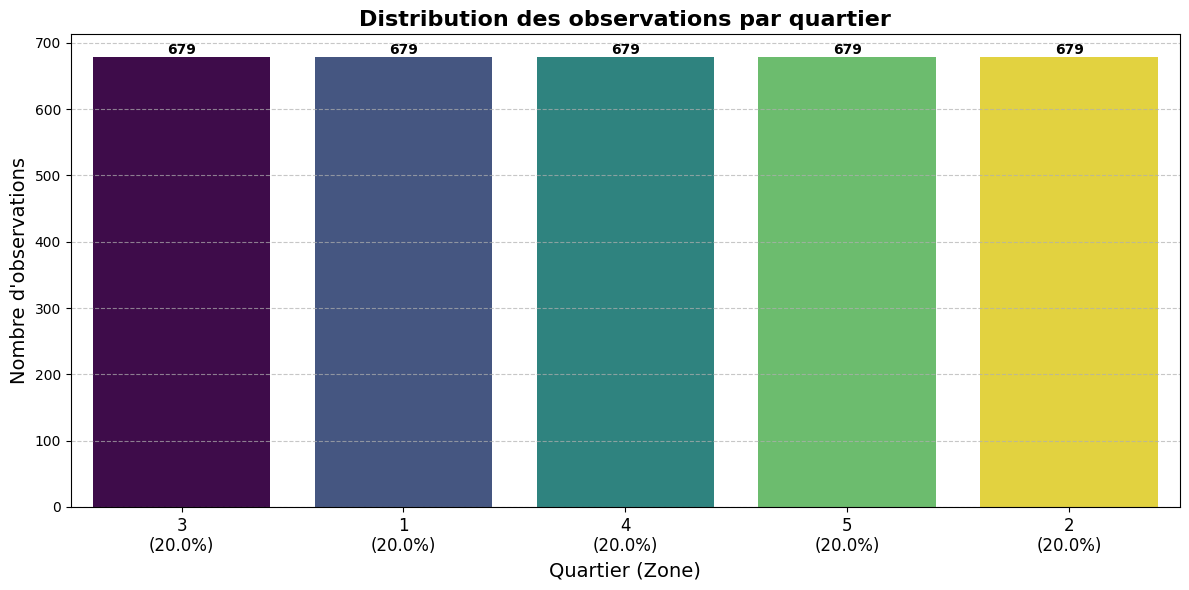

In [250]:
# Comptons les occurrences de chaque quartier
quartier_counts = df.group_by('quartier').len().sort('len', descending=True)
quartier_counts_pd = quartier_counts.to_pandas()

# Créons un graphique en barres plutôt qu'un histogramme pour plus de clarté
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='quartier', y='len', data=quartier_counts_pd, palette='viridis', hue='quartier', legend=False)

# Ajoutons les valeurs exactes au-dessus de chaque barre
for i, v in enumerate(quartier_counts_pd['len']):
    ax.text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.title('Distribution des observations par quartier', fontsize=16, fontweight='bold')
plt.xlabel('Quartier (Zone)', fontsize=14)
plt.ylabel("Nombre d'observations", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

total = quartier_counts_pd['len'].sum()
percentages = [f'{(x/total)*100:.1f}%' for x in quartier_counts_pd['len']]

plt.xticks(range(len(quartier_counts_pd)), [f"{q}\n({p})" for q, p in zip(quartier_counts_pd['quartier'], percentages)], fontsize=12)

plt.tight_layout()
plt.show()

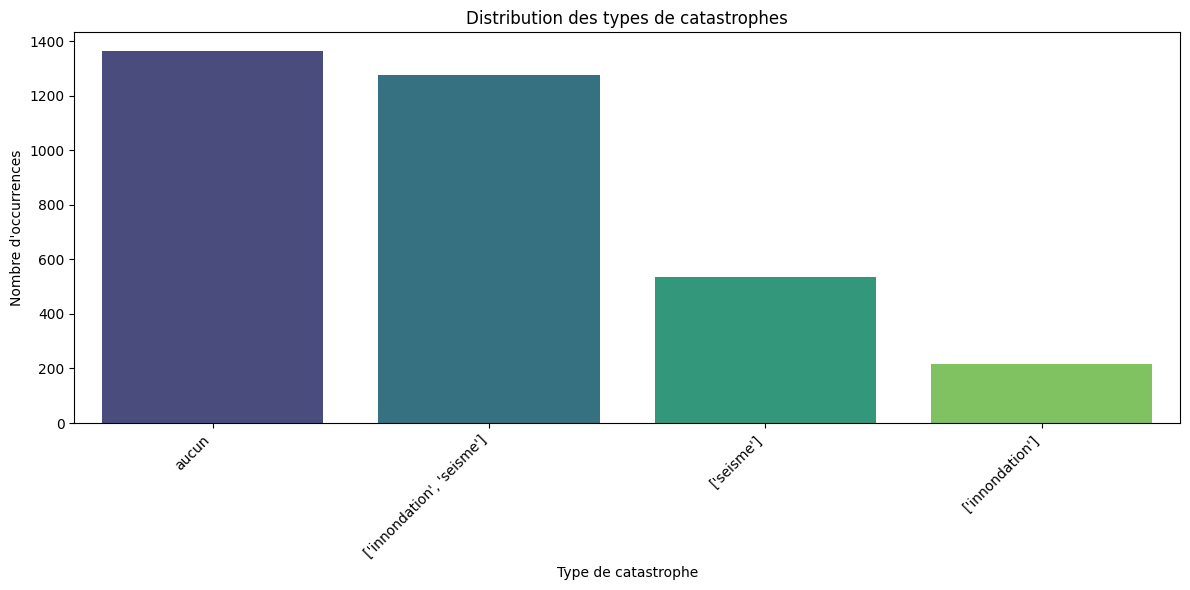

In [251]:
counts = df.group_by('catastrophe').len().sort('len', descending=True)

catastrophe_names = {i: name for i, name in enumerate(catastrophes)}

counts_pd = df_pandas['catastrophe'].map(lambda x: catastrophe_names.get(x, str(x))).value_counts().reset_index()
counts_pd.columns = ['nom_catastrophe', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(x='nom_catastrophe', y='count', data=counts_pd, palette='viridis', hue='nom_catastrophe', legend=False)
plt.title('Distribution des types de catastrophes')
plt.xlabel('Type de catastrophe')
plt.ylabel("Nombre d\'occurrences")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Distribution des types de catastrophes

Le graphique suivant montre la distribution des différents types de catastrophes dans notre jeu de données. Cela nous permet d'identifier si certains types sont surreprésentés ou sous-représentés, ce qui pourrait influencer nos analyses ultérieures.

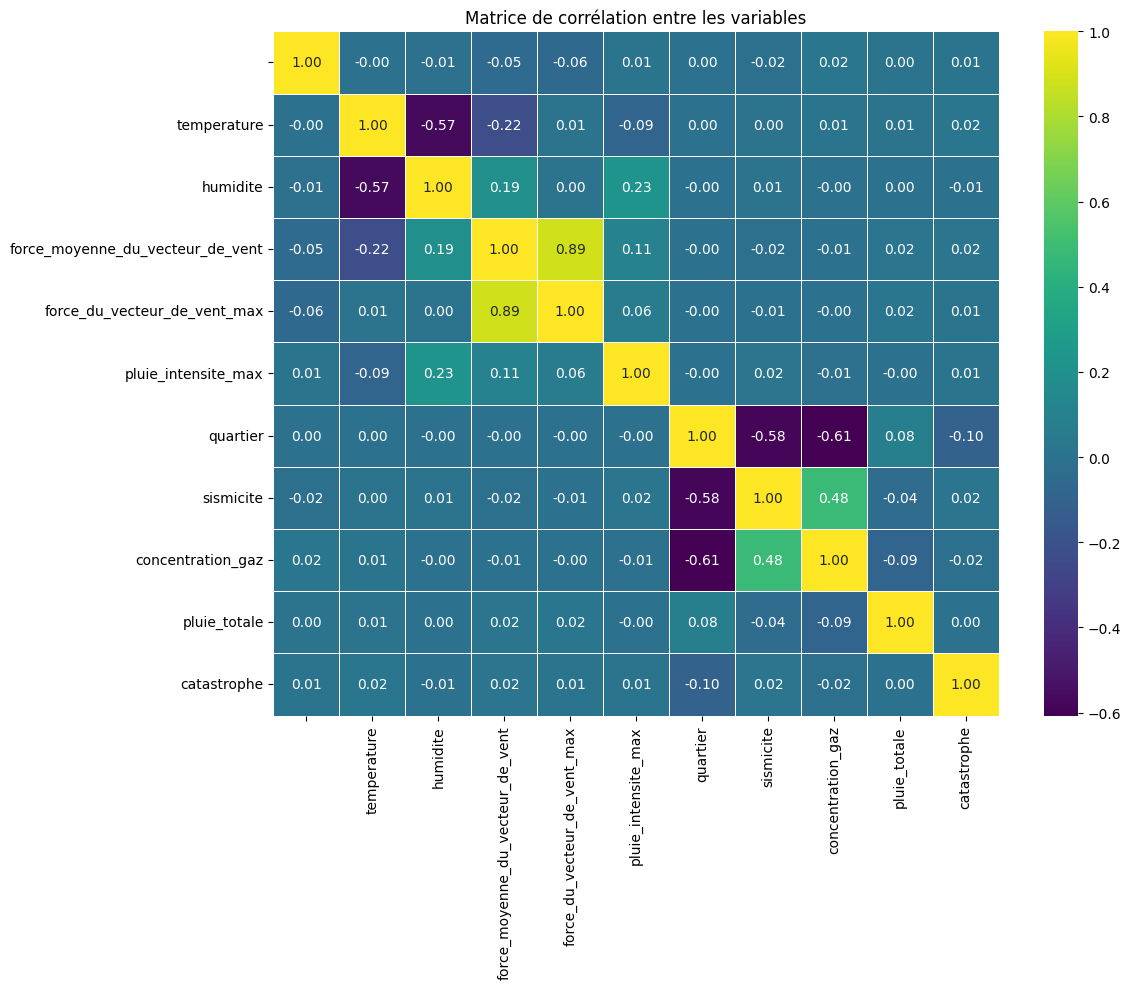

In [252]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation entre les variables')
plt.tight_layout()
plt.show()


## Matrice de corrélation des variables numériques

La matrice de corrélation ci-dessous nous permet d'identifier les relations linéaires entre les variables numériques. Des corrélations fortes (proches de 1 ou -1) indiquent une relation linéaire entre les variables, ce qui pourrait être utile pour comprendre les facteurs qui influencent les catastrophes.

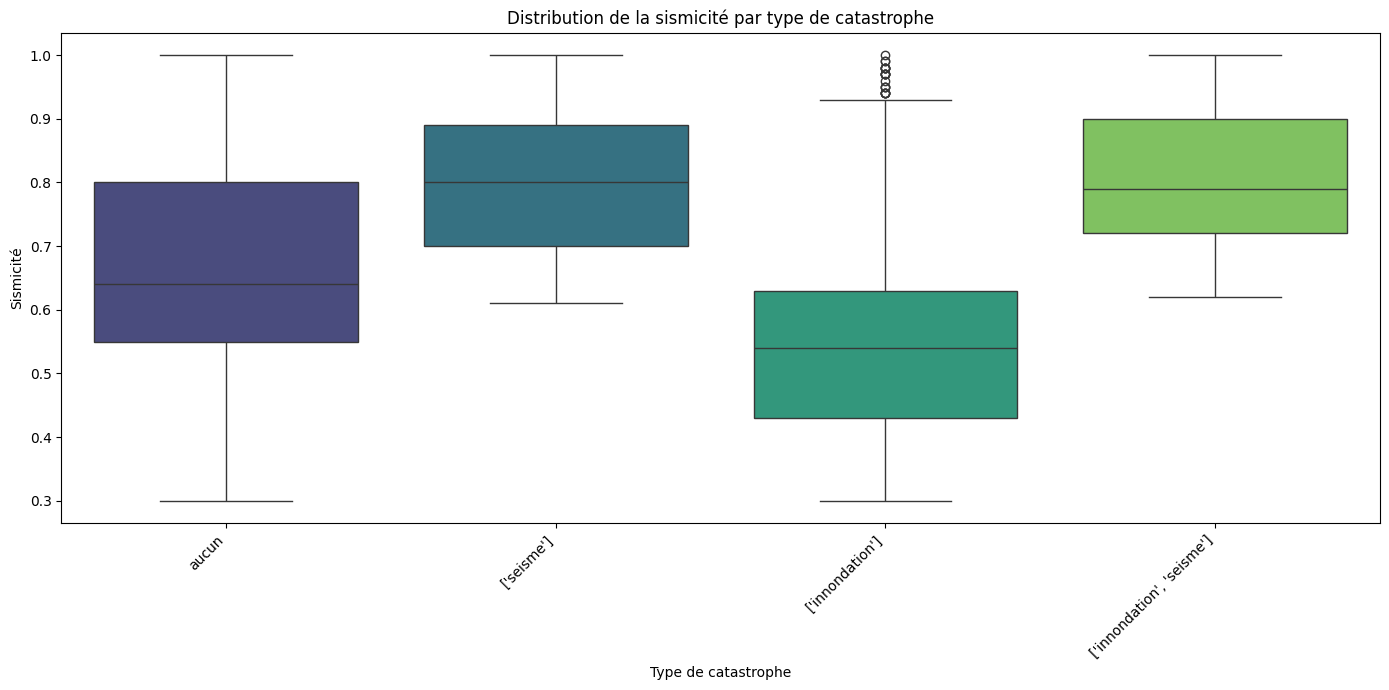

In [253]:
catastrophe_names = {i: name for i, name in enumerate(catastrophes)}
df_pd['nom_catastrophe'] = df_pd['catastrophe'].map(lambda x: catastrophe_names.get(x, str(x)))

plt.figure(figsize=(14, 7))
sns.boxplot(x='nom_catastrophe', y='sismicite', data=df_pd,  palette='viridis', hue='nom_catastrophe', legend=False)
plt.title('Distribution de la sismicité par type de catastrophe')
plt.xlabel('Type de catastrophe')
plt.ylabel('Sismicité')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Relation entre sismicité et types de catastrophes

Ce graphique en boîte à moustaches (boxplot) montre la distribution des valeurs de sismicité pour chaque type de catastrophe. Cela nous permet d'observer si certains types de catastrophes sont associés à des niveaux de sismicité particuliers.

/var/folders/5t/_4b401m524v50md9wzh4gxvh0000gn/T/ipykernel_29419/2498579840.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  quartier_catastrophe = df.group_by(['quartier', 'catastrophe']).count()


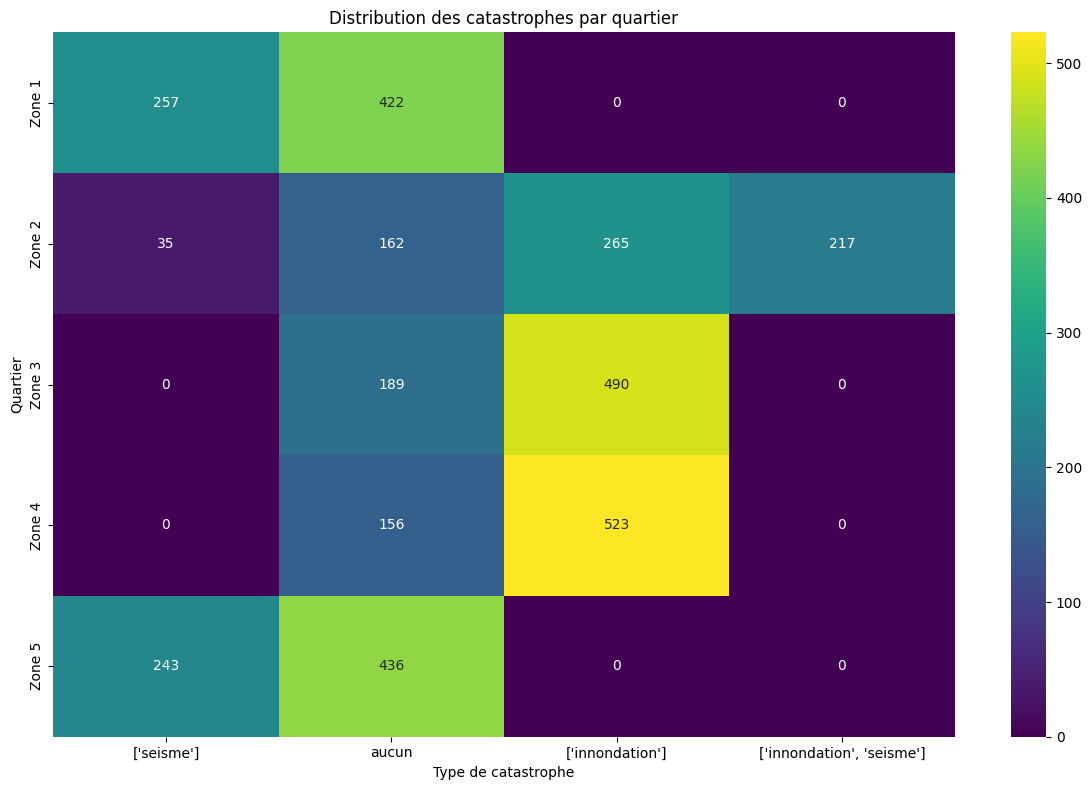

In [254]:
quartier_catastrophe = df.group_by(['quartier', 'catastrophe']).count()
quartier_catastrophe = quartier_catastrophe.pivot(index='quartier', on='catastrophe', values='count')
quartier_catastrophe = quartier_catastrophe.fill_null(0)

qc_pd = quartier_catastrophe.to_pandas()

qc_pd = qc_pd.drop(columns=['quartier'], errors='ignore')

qc_pd.columns = [catastrophe_names.get(int(col), col) if str(col).isdigit() else col for col in qc_pd.columns]

quartier_labels = [f'Zone {i}' for i in range(1, len(qc_pd) + 1)]

plt.figure(figsize=(12, 8))
sns.heatmap(qc_pd, annot=True, fmt='g', cmap='viridis', 
            yticklabels=quartier_labels) 

plt.title('Distribution des catastrophes par quartier')
plt.ylabel('Quartier')
plt.xlabel('Type de catastrophe')
plt.tight_layout()
plt.show()

## Distribution des catastrophes par quartier

La carte thermique (heatmap) suivante montre la répartition des différents types de catastrophes par quartier. Cette visualisation nous permet d'identifier si certains quartiers sont plus vulnérables à des types spécifiques de catastrophes.

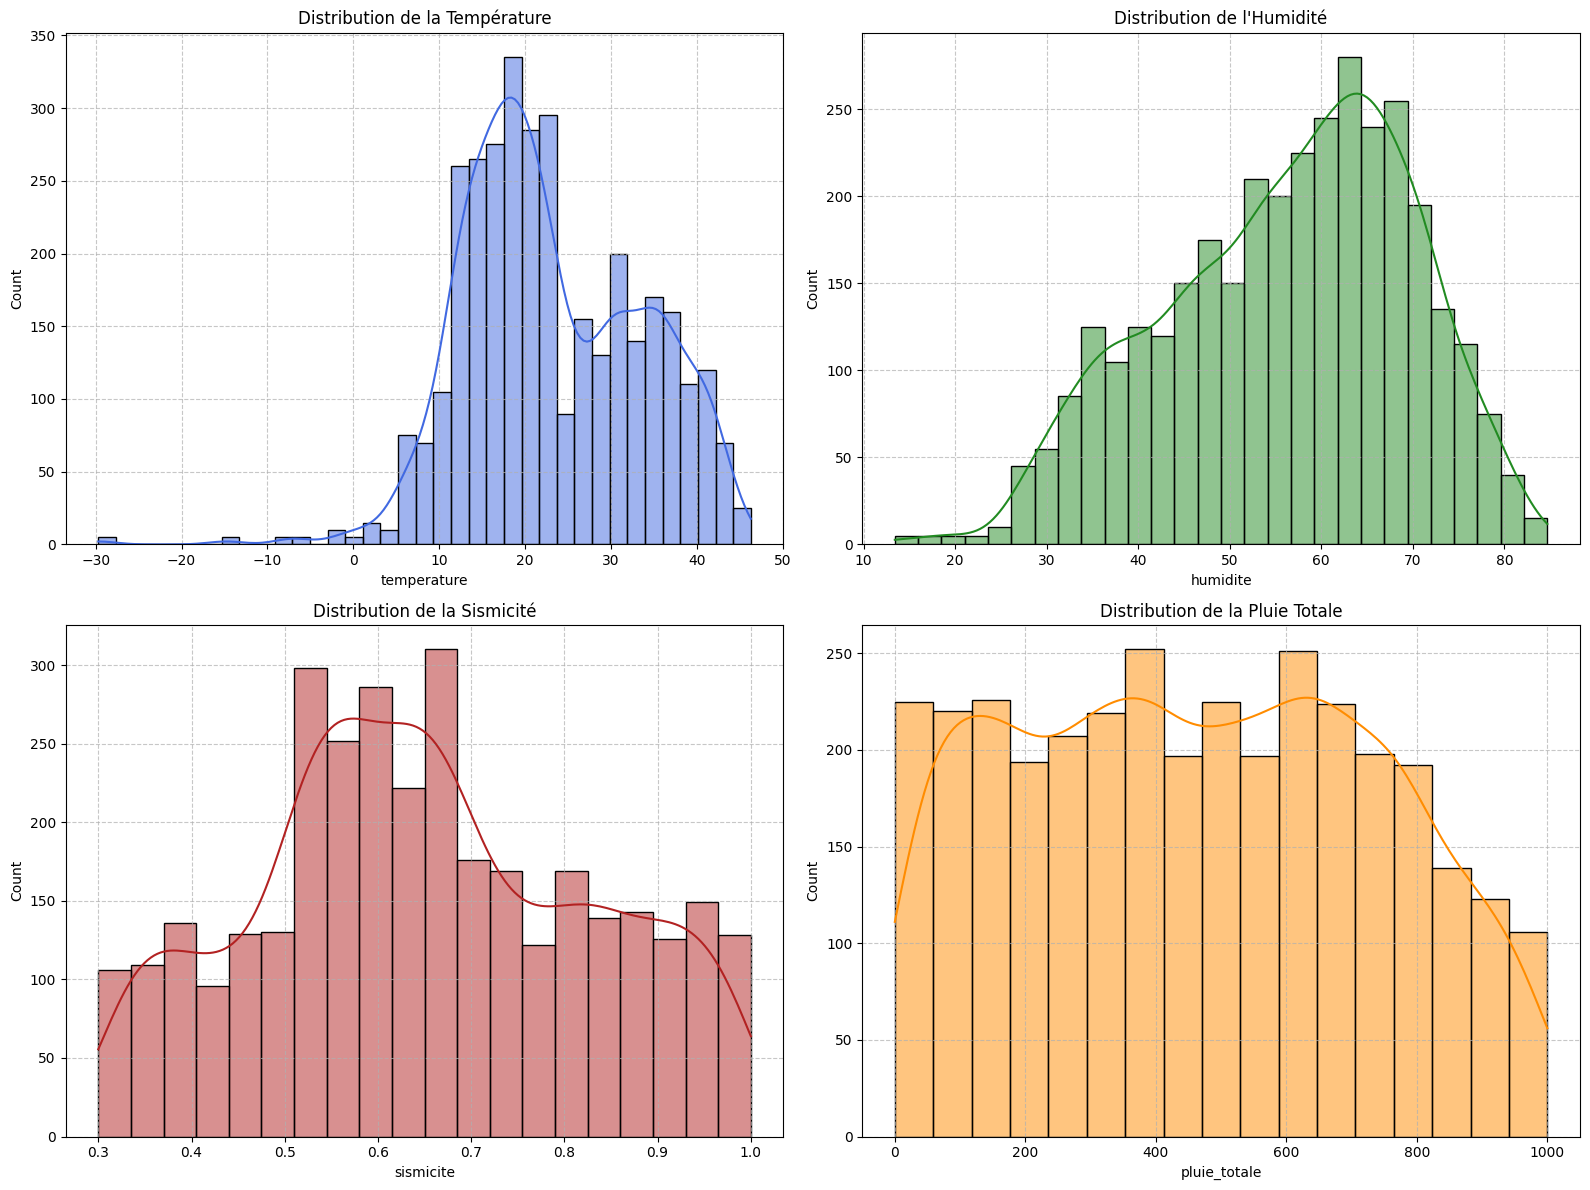

In [255]:

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(df_pd['temperature'], kde=True, ax=axes[0, 0], color='royalblue')
axes[0, 0].set_title('Distribution de la Température')
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

sns.histplot(df_pd['humidite'], kde=True, ax=axes[0, 1], color='forestgreen')
axes[0, 1].set_title('Distribution de l\'Humidité')
axes[0, 1].grid(True, linestyle='--', alpha=0.7)

sns.histplot(df_pd['sismicite'], kde=True, ax=axes[1, 0], color='firebrick')
axes[1, 0].set_title('Distribution de la Sismicité')
axes[1, 0].grid(True, linestyle='--', alpha=0.7)

sns.histplot(df_pd['pluie_totale'], kde=True, ax=axes[1, 1], color='darkorange')
axes[1, 1].set_title('Distribution de la Pluie Totale')
axes[1, 1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Distribution des variables environnementales

Les histogrammes suivants montrent la distribution des principales variables environnementales (température, humidité, sismicité, pluie totale) dans notre jeu de données. Ces visualisations nous permettent de comprendre la répartition des valeurs et d'identifier d'éventuelles anomalies ou valeurs extrêmes.

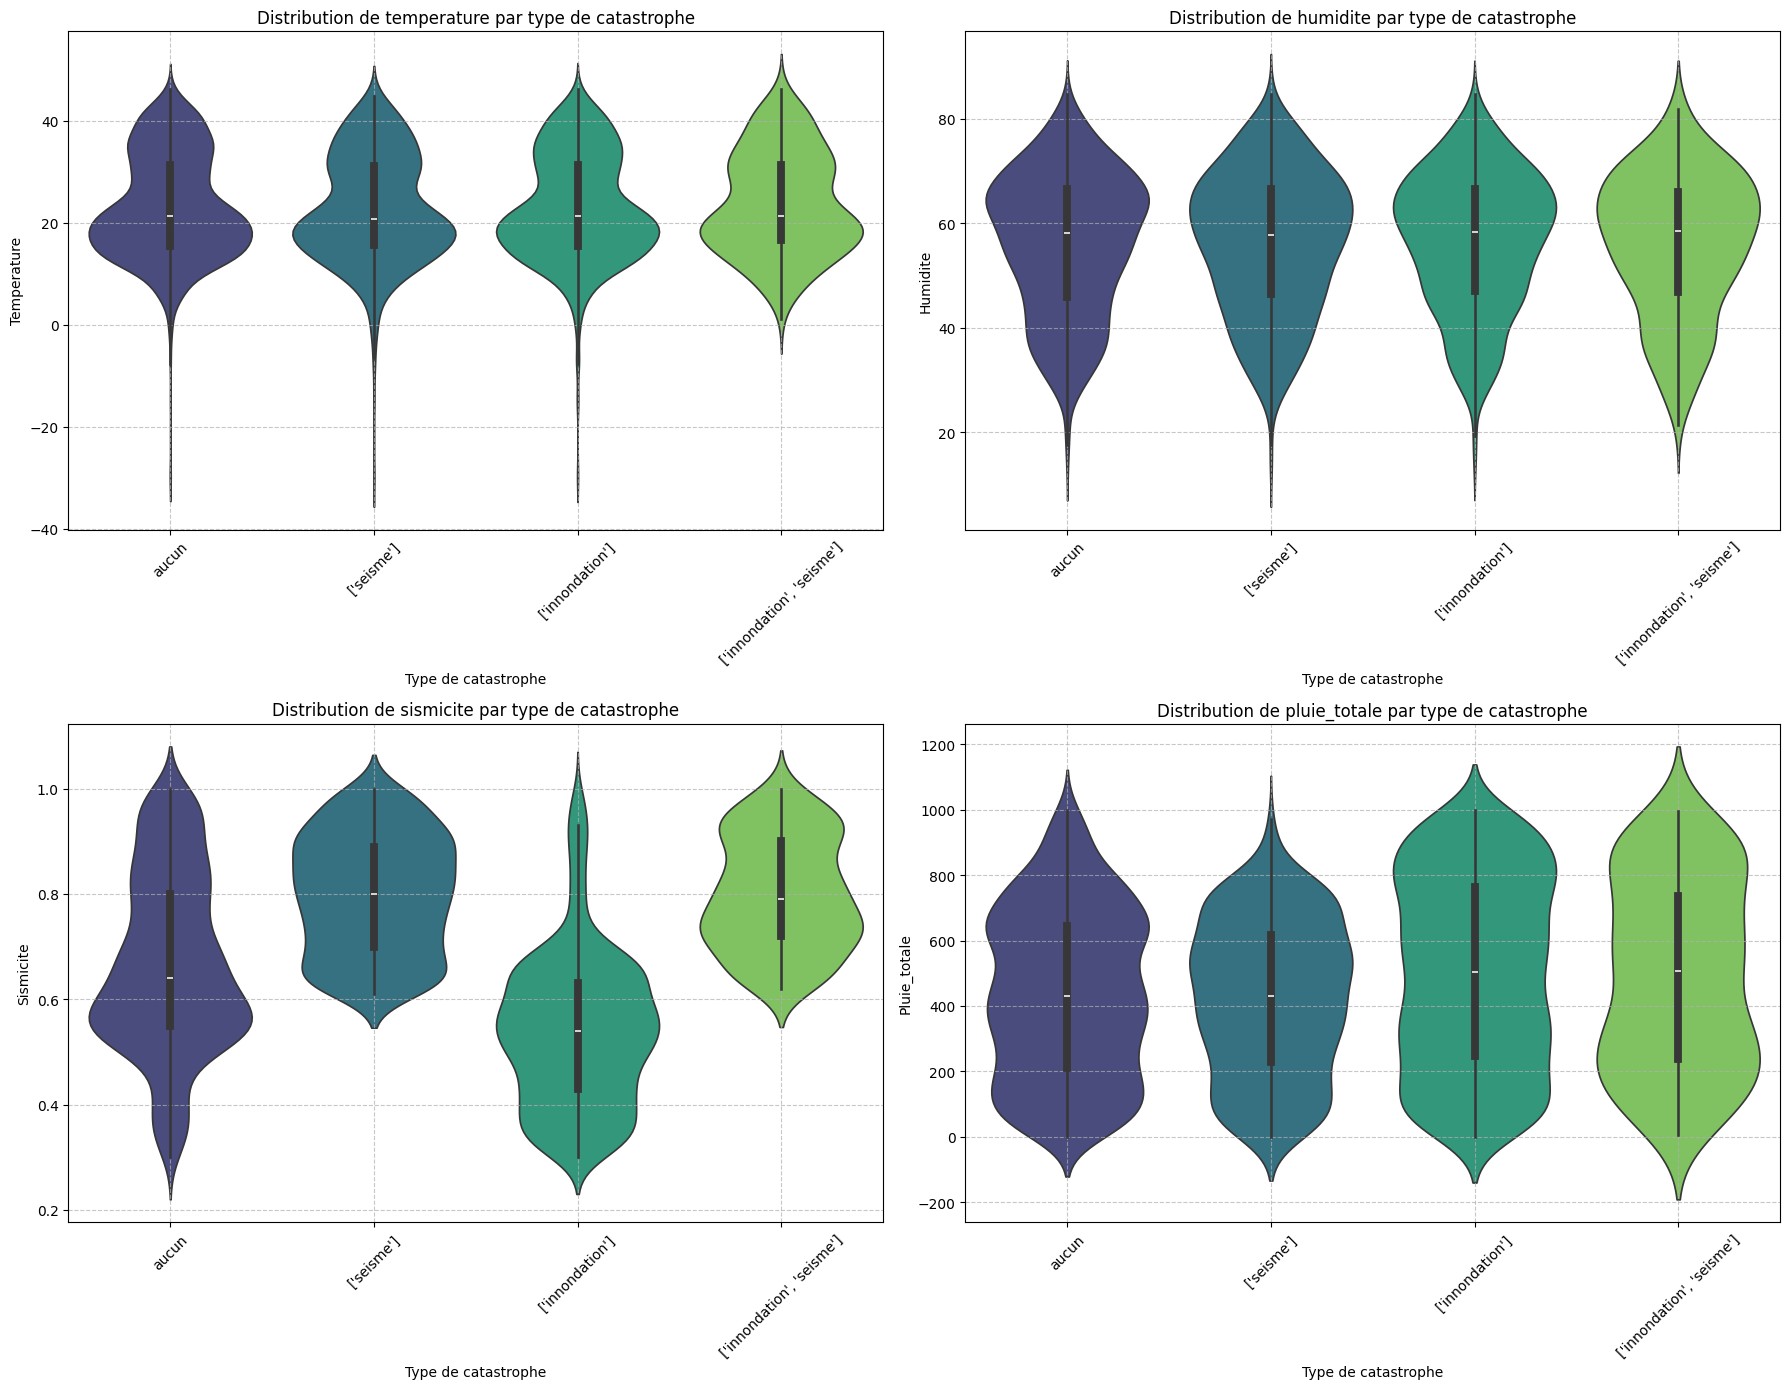

In [256]:
catastrophe_names = {i: name for i, name in enumerate(catastrophes)}
df_pd['nom_catastrophe'] = df_pd['catastrophe'].map(lambda x: catastrophe_names.get(x, str(x)))

variables = ['temperature', 'humidite', 'sismicite', 'pluie_totale']

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.violinplot(x='nom_catastrophe', y=var, data=df_pd, ax=axes[i], hue='nom_catastrophe', palette='viridis', legend=False)
    axes[i].set_title(f'Distribution de {var} par type de catastrophe')
    axes[i].set_xlabel('Type de catastrophe')
    axes[i].set_ylabel(var.capitalize())
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Distributions des variables environnementales par type de catastrophe (Violin Plots)

Les graphiques en violon (violin plots) ci-dessus offrent une visualisation détaillée de la distribution des variables environnementales pour chaque type de catastrophe. Contrairement aux boxplots, ils montrent la densité de probabilité complète, ce qui permet de mieux comprendre les distributions multimodales ou asymétriques.

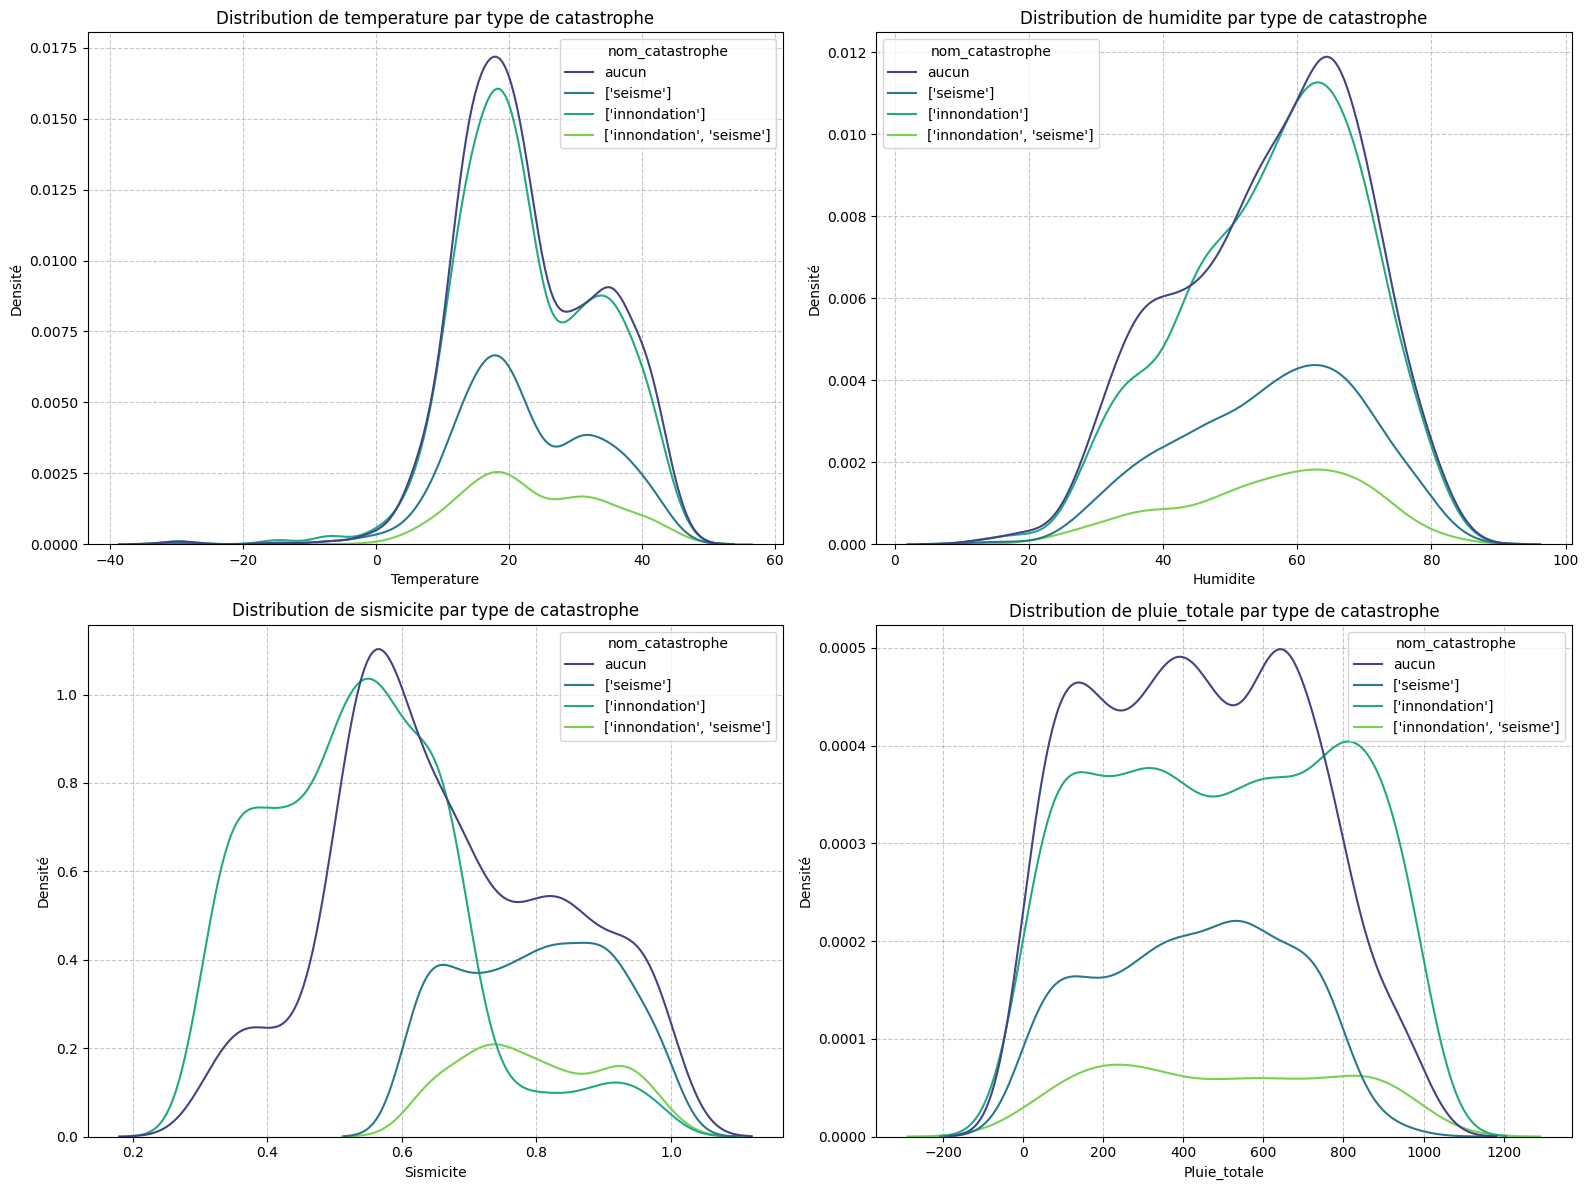

In [257]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

variables = ['temperature', 'humidite', 'sismicite', 'pluie_totale']

for i, var in enumerate(variables):
    ax = axes[i//2, i%2]
    sns.kdeplot(data=df_pd, x=var, hue='nom_catastrophe', ax=ax, palette='viridis')
    ax.set_title(f'Distribution de {var} par type de catastrophe')
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel('Densité')
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Comparaison des distributions de densité par type de catastrophe

Les graphiques de densité (KDE plots) suivants permettent de comparer directement les distributions des variables environnementales entre les différents types de catastrophes. Cette comparaison aide à identifier si certaines catastrophes sont associées à des profils environnementaux spécifiques.

# Vérification de la continuité des dates

In [258]:
dates_uniques = df.select('date').unique().sort('date')

dates_liste = dates_uniques['date'].to_list()

print(f"Nombre total de dates uniques: {len(dates_liste)}")

diff_dates = []
dates_manquantes = []

for i in range(1, len(dates_liste)):
    diff = dates_liste[i] - dates_liste[i-1]
    diff_jours = diff.total_seconds() / (60*60*24)  

    if diff_jours > 1: 
        dates_manquantes.append((dates_liste[i-1], dates_liste[i], diff_jours))
    
    diff_dates.append(diff_jours)

if diff_dates:
    print(f"\nStatistiques sur les écarts entre dates consécutives (en jours):")
    print(f"Minimum: {min(diff_dates)}")
    print(f"Maximum: {max(diff_dates)}")
    print(f"Moyenne: {sum(diff_dates)/len(diff_dates):.2f}")

    if dates_manquantes:
        print(f"\nIntervalles avec coupures détectés:")
        for debut, fin, jours in dates_manquantes:
            print(f"Coupure entre {debut} et {fin} ({jours:.0f} jours)")
    else:
        print("\nAucune coupure détectée dans les dates. La série temporelle est continue.")
else:
    print("Pas assez de dates pour analyser la continuité.")

Nombre total de dates uniques: 679

Statistiques sur les écarts entre dates consécutives (en jours):
Minimum: 1.0
Maximum: 39.0
Moyenne: 1.08

Intervalles avec coupures détectés:
Coupure entre 2170-02-01 et 2170-02-03 (2 jours)
Coupure entre 2170-02-10 et 2170-02-12 (2 jours)
Coupure entre 2170-04-21 et 2170-04-23 (2 jours)
Coupure entre 2170-08-09 et 2170-09-17 (39 jours)
Coupure entre 2170-09-29 et 2170-10-01 (2 jours)
Coupure entre 2170-11-19 et 2170-11-21 (2 jours)
Coupure entre 2171-01-15 et 2171-01-17 (2 jours)
Coupure entre 2171-01-27 et 2171-01-29 (2 jours)
Coupure entre 2171-05-03 et 2171-05-05 (2 jours)
Coupure entre 2171-08-04 et 2171-08-06 (2 jours)
Coupure entre 2171-09-20 et 2171-09-22 (2 jours)
Coupure entre 2171-10-18 et 2171-10-20 (2 jours)
Coupure entre 2171-11-01 et 2171-11-03 (2 jours)
Coupure entre 2171-11-17 et 2171-11-19 (2 jours)


## Détection des coupures dans la série temporelle

Le code ci-dessus identifie les périodes où il y a des jours manquants dans notre série de données. Nous calculons également des statistiques sur les écarts entre dates consécutives pour comprendre la distribution temporelle de nos observations.

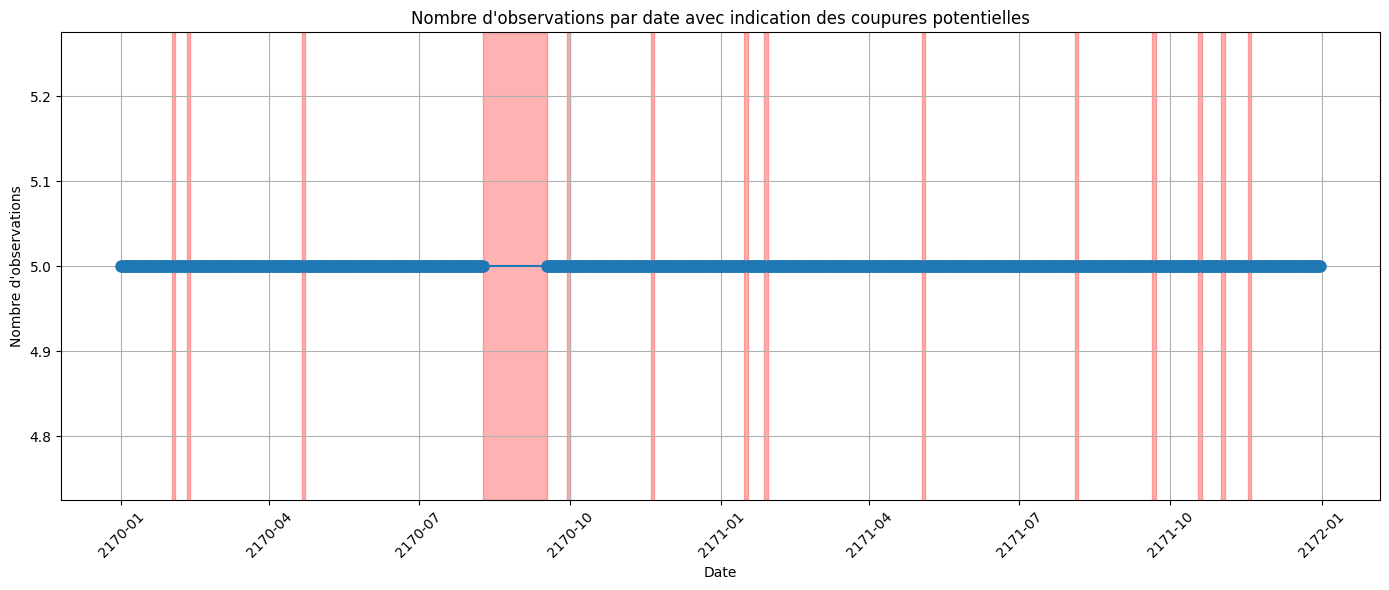

In [259]:
# Vérification de la continuité des dates
date_count = df.group_by('date').agg(
    pl.len().alias('nombre_observations')
).sort('date')

date_count_pd = date_count.to_pandas()
date_count_pd.set_index('date', inplace=True)

plt.figure(figsize=(14, 6))

plt.plot(date_count_pd.index, date_count_pd['nombre_observations'], 'o-', markersize=8)

if dates_manquantes:
    for debut, fin, _ in dates_manquantes:
        plt.axvspan(debut, fin, color='red', alpha=0.3)

plt.title('Nombre d\'observations par date avec indication des coupures potentielles')
plt.xlabel('Date')
plt.ylabel('Nombre d\'observations')
plt.grid(True)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

## Visualisation des observations par date et des coupures temporelles

Ce graphique représente le nombre d'observations pour chaque date dans notre jeu de données. Les zones rouges mettent en évidence les périodes où des coupures ont été détectées (jours manquants). Cette visualisation nous aide à comprendre la distribution temporelle des données et à identifier les périodes potentiellement problématiques pour l'analyse.

# Conclusion

Cette analyse exploratoire des données nous a permis de:

1. **Nettoyer et préparer** les données pour l'analyse en traitant les problèmes de formatage et en encodant les variables catégorielles.

2. **Explorer les distributions** des différentes variables environnementales et comprendre leur relation avec les types de catastrophes.

3. **Identifier les corrélations** entre les variables numériques, ce qui peut nous aider à comprendre les facteurs contribuant aux différentes catastrophes.

4. **Analyser la répartition géographique** des catastrophes par quartier, révélant si certaines zones sont plus vulnérables à des types spécifiques d'événements.

5. **Examiner la continuité temporelle** des données pour identifier d'éventuelles périodes manquantes ou des motifs temporels dans l'occurrence des catastrophes.

Ces informations constituent une base solide pour développer des modèles prédictifs ou des systèmes d'alerte précoce concernant les catastrophes naturelles.